In [1]:
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import ensemble
from sklearn.preprocessing import StandardScaler
from custom_datasets import CustomDataset
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import make_scorer
#define your own mse and set greater_is_better=False
mse = make_scorer(mean_squared_error,greater_is_better=False)

In [3]:
os.makedirs('./weights', exist_ok=True)

In [54]:
df_train = pd.read_csv('../datasets/kitti_train.csv')
df_valid = pd.read_csv('../datasets/kitti_valid.csv')
df_test = pd.read_csv('../datasets/kitti_test.csv')

In [55]:
df_train['class'].unique()

array(['person', 'car', 'truck', 'train', 'bicycle', 'Misc'], dtype=object)

In [56]:
train = df_train.drop(['filename', 'class', 'weather'], axis=1)
valid = df_valid.drop(['filename', 'class', 'weather'], axis=1)
test = df_test.drop(['filename', 'class', 'weather'], axis=1)

In [57]:
# onehot encoding
class_dummy = pd.get_dummies(df_train['class'])
df_train = pd.concat([df_train, class_dummy], axis=1)

class_dummy = pd.get_dummies(df_valid['class'])
df_valid = pd.concat([df_valid, class_dummy], axis=1)

class_dummy = pd.get_dummies(df_test['class'])
df_test = pd.concat([df_test, class_dummy], axis=1)

In [58]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22022 entries, 0 to 22021
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   filename    22022 non-null  object 
 1   class       22022 non-null  object 
 2   xmin        22022 non-null  float64
 3   ymin        22022 non-null  float64
 4   xmax        22022 non-null  float64
 5   ymax        22022 non-null  float64
 6   angle       22022 non-null  float64
 7   zloc        22022 non-null  float64
 8   weather     22022 non-null  object 
 9   depth_y     22022 non-null  int64  
 10  depth_mean  22022 non-null  float64
 11  depth_x     22022 non-null  int64  
 12  depth_min   22022 non-null  float64
 13  width       22022 non-null  float64
 14  height      22022 non-null  float64
 15  Misc        22022 non-null  uint8  
 16  bicycle     22022 non-null  uint8  
 17  car         22022 non-null  uint8  
 18  person      22022 non-null  uint8  
 19  train       22022 non-nul

In [59]:
def scale(df, variable):
    for v in variable:
        scaler = StandardScaler()
        feat = np.array(df[v]).reshape(-1,1)
        df[v] = scaler.fit_transform(feat)
    return df

In [60]:
variable = ['xmin', 'ymin', 'xmax', 'ymax', 'angle', 'depth_y', 'depth_mean', 'depth_x', 'depth_min', 'width', 'height']

df_train = scale(df_train, variable)
df_valid = scale(df_valid, variable)
df_test = scale(df_test, variable)

In [61]:
df_train.columns

Index(['filename', 'class', 'xmin', 'ymin', 'xmax', 'ymax', 'angle', 'zloc',
       'weather', 'depth_y', 'depth_mean', 'depth_x', 'depth_min', 'width',
       'height', 'Misc', 'bicycle', 'car', 'person', 'train', 'truck'],
      dtype='object')

In [62]:
train.columns


Index(['xmin', 'ymin', 'xmax', 'ymax', 'angle', 'zloc', 'depth_y',
       'depth_mean', 'depth_x', 'depth_min', 'width', 'height'],
      dtype='object')

In [63]:
X_train = train.loc[:, train.columns != 'zloc']
y_train = train.loc[:, train.columns == 'zloc']

X_valid = valid.loc[:, valid.columns != 'zloc']
y_valid = valid.loc[:, valid.columns == 'zloc']

X_test = test.loc[:, test.columns != 'zloc']
y_test = test.loc[:, test.columns == 'zloc']

In [64]:
X_train.head()

,xmin,ymin,xmax,ymax,angle,depth_y,depth_mean,depth_x,depth_min,width,height
0,711.87683,151.95032,809.37300,308.49020,-0.20,206,1.353822,740,0.924987,97.49617,156.53988
1,390.57785,181.78027,421.47256,200.24520,1.85,199,8.203516,402,7.598885,30.89471,18.46493
2,655.78680,190.24402,698.48170,221.83864,-1.67,215,5.255319,688,4.330514,42.69490,31.59462
3,612.12930,176.14651,729.66540,282.53200,1.55,223,2.592226,714,1.617154,117.53610,106.38549
4,283.69547,184.47151,343.14720,211.07599,1.96,205,5.243353,289,4.655178,59.45173,26.60448


In [65]:
X_train.columns

Index(['xmin', 'ymin', 'xmax', 'ymax', 'angle', 'depth_y', 'depth_mean',
       'depth_x', 'depth_min', 'width', 'height'],
      dtype='object')

In [66]:
X_test.columns

Index(['xmin', 'ymin', 'xmax', 'ymax', 'angle', 'depth_y', 'depth_mean',
       'depth_x', 'depth_min', 'width', 'height'],
      dtype='object')

In [67]:
#텐서화
X_train = torch.FloatTensor(X_train.values)
y_train = torch.FloatTensor(y_train.values)

X_valid = torch.FloatTensor(X_valid.values)
y_valid = torch.FloatTensor(y_valid.values)

X_test = torch.FloatTensor(X_test.values)
y_test = torch.FloatTensor(y_test.values)

In [68]:
class Zloc_Estimaotor(nn.Module):
      def __init__(self):
        super().__init__()
        #Layer
        layersize=[16,32,64,32,16,8,2]
        layerlist= []
        n_in=11
        for i in layersize:
            layerlist.append(nn.Linear(n_in,i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(0.4))
            n_in=i           
        layerlist.append(nn.Linear(layersize[-1],1))
        layerlist.append(nn.Sigmoid(inplace=True))
        
        self.layers=nn.Sequential(*layerlist)
        
      def forward(self, x):
        out= self.layers(x)
        return out

In [69]:
# Function to save the model 
def saveModel(model): 
    path = "NetModel2.pth" 
    torch.save(model.state_dict(), path) 

In [118]:
def train_model(model, train_dataloader, valid_dataloader, loss_fn, lr=1e-5, batch_size=512, epochs=100, validate=False):
  param_lrs = [{'params':param, 'lr':lr} for param in model.parameters()]
  optimizer = torch.optim.Adam(param_lrs, lr=lr) #weighted decay 설정하여고고
  
  # Define your execution device
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  # Convert model parameters and buffers to CPU or Cuda
  model.to(device)

  best_rmse = np.Inf
  print("Begin training...") 
  res_train = []
  res_valid = []
  res_rmse = []
  for epoch in range(1, epochs+1): 
    running_train_loss = 0.0 
    running_rmse = 0.0 
    running_val_loss = 0.0 
    total = 0 

    for batch_ind, samples in enumerate(train_dataloader):
      x_train, y_train = samples
      optimizer.zero_grad()
      pred = model.forward(x_train)
      train_loss = loss_fn(pred, y_train)
      train_loss.backward()
      optimizer.step()
      running_train_loss += train_loss.item()

    train_loss_value = running_train_loss/len(train_dataloader)
    
    with torch.no_grad(): 
      #model.eval() 
      for data in valid_dataloader: 
        inputs, outputs = data 
        predicted_outputs = model(inputs) 
        val_loss = loss_fn(predicted_outputs, outputs) 
      
        # The label with the highest value will be our prediction 
        running_val_loss += val_loss.item()  
        total += 1
        rmse = mean_squared_error(outputs, predicted_outputs)
        running_rmse += rmse

    # Calculate validation loss value 
    val_loss_value = running_val_loss/len(valid_dataloader)  
    rmse = (running_rmse / total)**0.5
    res_train.append(rmse)

    if rmse < best_rmse:
      saveModel(model)
      best_rmse = rmse
    
    # Print the statistics of the epoch 
    print('Epoch {0}/{1} - loss: {2:.4f} / val_loss: {3:.4f} - RMSE: {4:.4f}'.format(epoch, epochs, train_loss_value, val_loss_value, rmse))
    res_train.append(train_loss_value)
    res_valid.append(val_loss_value)
    res_rmse.append(rmse)
  return [res_train, res_valid, res_rmse]

In [119]:
def predict(test_dataloader): 
    # Load the model that we saved at the end of the training loop 
    model = Zloc_Estimaotor()
    path = "NetModel.pth" 
    model.load_state_dict(torch.load(path)) 
     
    running_rmse = 0 
    total = 0 
    pred = []
 
    with torch.no_grad(): 
      model.eval()
      for data in test_dataloader: 
        inputs, outputs = data 
        inputs=inputs.unsqueeze(0)
        outputs = outputs.to(torch.float32) 
        predicted_outputs = model(inputs) 
        pred.append(float(predicted_outputs))
        total += 1
        rmse = mean_squared_error(outputs, predicted_outputs)
        running_rmse += rmse
 
      print('RMSE:',(running_rmse / total)**0.5)
    return pred

In [120]:
train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)
train_dataloader = DataLoader(train_dataset, batch_size=4)
valid_dataloader = DataLoader(valid_dataset, batch_size=4)



In [121]:
import torch.nn.init as init
def weight_init(m):
    if isinstance(m, nn.Linear): # nn.Linear에 있는 가중치에만 적용
        init.kaiming_uniform_(m.weight.data) # He initialization

model = Zloc_Estimaotor()
model.apply(weight_init) # 가중치 초깃값 설정
loss_func = nn.MSELoss()

In [122]:
model

Zloc_Estimaotor(
  (layers): Sequential(
    (0): Linear(in_features=11, out_features=16, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=16, out_features=32, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=32, out_features=64, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=64, out_features=32, bias=True)
    (13): ReLU(inplace=True)
    (14): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Dropout(p=0.4, inplace=False)
    (16): Linear(in_features=32, out_features=16, bias=True)
    (17): ReLU(inplace=True)

In [128]:
res = train_model(model, train_dataloader, valid_dataloader, loss_func, epochs=5)#올리기위해 5로만 잡아놓음

Begin training...
Epoch 1/5 - loss: 1009.7846 / val_loss: 1017.2973 - RMSE: 31.8951
Epoch 2/5 - loss: 1002.6603 / val_loss: 1008.4885 - RMSE: 31.7567
Epoch 3/5 - loss: 995.3517 / val_loss: 1001.7728 - RMSE: 31.6508
Epoch 4/5 - loss: 988.6625 / val_loss: 994.3904 - RMSE: 31.5340
Epoch 5/5 - loss: 980.9247 / val_loss: 986.3478 - RMSE: 31.4062


In [129]:
res_train, res_valid, rmse = res

In [130]:
test_dataset = TensorDataset(X_test, y_test)

test_dataloader = DataLoader(test_dataset, batch_size=4)

In [131]:
pred = predict(test_dataset)

RMSE: 4.680703207927983


In [132]:
res_df = pd.DataFrame([res_train[1::2], res_valid]).transpose()
res_df.columns = ['train', 'valid']

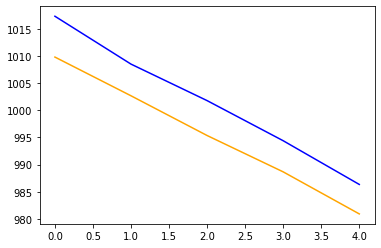

In [133]:

plt.plot(res_train[1::2], color='orange')
plt.plot(res_valid, color='blue')
plt.show()

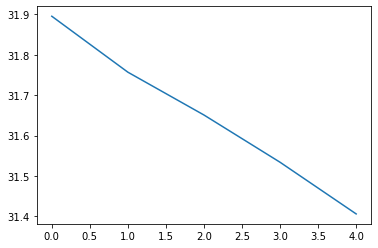

In [134]:
plt.plot(rmse)
plt.show()